[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'^GSPC'}, xlabel='Date'>

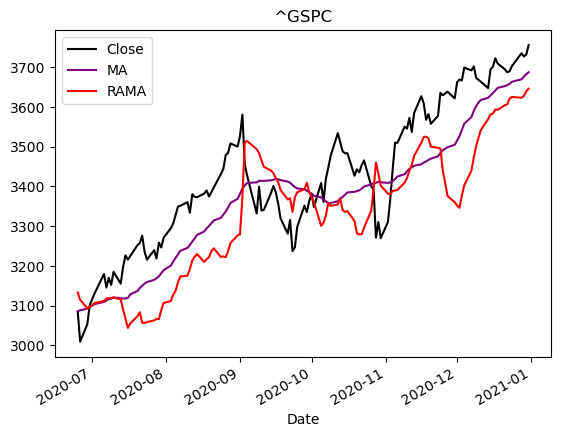

In [122]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfinance.ols import RollingOLS, PandasRollingOLS
from scipy.stats import norm
import pandas_ta as ta

def steyx(df):
    y=df['Close'].values
    x=df['X'].values
    fit = np.polyfit(x,y,deg=1)
    n = len(x)
    m = fit[0]
    c = fit[1]
    y_pred = m*x+c
    STEYX = (((y-y_pred)**2).sum()/(n-2))**0.5
    return STEYX

def rolling_pipe(dataframe,window):
    return pd.Series([dataframe.iloc[i-window: i].pipe(steyx) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index)

window=25
ticker='^GSPC'
df=yf.download(tickers= ticker,start= '2020-4-1', end='2021-1-1',interval = "1d",
                     group_by = 'column',auto_adjust = True, prepost = True, 
                     proxy = None)
df['X'] = np.arange(len(df))
df['MA']=df['Close'].rolling(window).mean()
r=PandasRollingOLS(df['Close'], df['X'], window)
df['alpha']=r.alpha
df['beta']=r.beta['feature1']
df['MPE']=r.alpha+r.beta['feature1']*df['X']
df['SEE']=df.pipe(rolling_pipe, window)
df['SEE_rank']=(df['SEE'].rolling(window).rank(pct=True) - 1/window) * window/(window-1)
df['RAMA']=df['alpha']+df['beta']*(df['X']-(window-1-(df['SEE_rank']*(window-1))))
df.loc[df.index>'2020-06-24'][['Close','MA','RAMA']].plot(title=ticker,color=['black','purple','red'])